In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.model_selection import train_test_split

# Constants

In [2]:
alpha = 1.0

# Preprocessing

In [3]:
plt.rcParams["figure.figsize"] = (15, 10)
pd.options.display.max_columns = 100

In [4]:
%%time
df = pd.read_csv('data/train_2011_2012_2013.csv', sep=";", nrows=1e10)

<string>:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 3min 12s, sys: 39.5 s, total: 3min 52s
Wall time: 4min 16s


In [5]:
target = "CSPL_RECEIVED_CALLS"

In [6]:
df.DATE = pd.to_datetime(df.DATE)

In [7]:
import datetime

get the time slot of the day (0 for 00:00, 1 for 00:30, ... 47 for 23:30)

In [8]:
def get_slot(timestamp):
    assert timestamp.minute in [0, 30]
    return 2 * timestamp.hour + (timestamp.minute == 30)

In [37]:
%%time
df['slot'] = df.DATE.apply(get_slot)

CPU times: user 46 s, sys: 2.47 s, total: 48.5 s
Wall time: 48.9 s


In [41]:
%%time
df['dayofweek'] = df.DATE.apply(lambda x: x.dayofweek)

CPU times: user 47.5 s, sys: 3.03 s, total: 50.5 s
Wall time: 52.3 s


In [69]:
%%time
df['ass_hashed'] = df.ASS_ASSIGNMENT.apply(hash)

CPU times: user 3.99 s, sys: 778 ms, total: 4.77 s
Wall time: 4.89 s


In [31]:
# 1 for night, 0 for day

In [11]:
df.loc[df.TPER_TEAM == 'Nuit', 'TPER_TEAM'] = 0
df.loc[df.TPER_TEAM == 'Jours', 'TPER_TEAM'] = 1

In [12]:
df.TPER_HOUR.unique()

array([ 1,  0,  2,  3,  4,  5,  7,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [13]:
# the column ACD_COD only contains 1's
del df['ACD_COD']
# the column ACD_LIB only contains 'Entity1 G3RV6'
del df['ACD_LIB']
# the column ASS_SOC_MERE only contains 'Entity1 France'
del df['ASS_SOC_MERE']

#### Some columns contain text and only a small number of different values. For each of them, we create a binary_feature

In [14]:
def add_binary_variables(column):
    for e in df[column].unique():
        print("Adding column", column + '_' + e)
        df[column + '_' + e] = 0
        df.loc[df[column] == e, column + '_' + e] = 1

add_binary_variables("ASS_DIRECTORSHIP")
add_binary_variables("ASS_PARTNER")
add_binary_variables("ASS_POLE")

##### We no longer need the original columns

In [57]:
del df['ASS_DIRECTORSHIP']
del df['ASS_POLE']
del df['ASS_PARTNER']

For the moment, we'll drop ASS_BEGIN (70% of the time, it's the same date anyway) and ASS_END (98% of the time, it's '9999-12-31 00:00:00.000').
### It is important that at some time we check they do not contain valuable information (they seem to)!

In [78]:
for e in df.ASS_BEGIN.unique():
    print("Mean target value for ", e, df[df.ASS_BEGIN == e][target].mean())

Mean target value for  2001-01-01 00:00:00.000 1.57073678295
Mean target value for  2009-01-01 00:00:00.000 0.379920976766
Mean target value for  2007-04-16 00:00:00.000 1.01699948037
Mean target value for  2006-07-01 00:00:00.000 0.0131761442441
Mean target value for  2001-04-01 00:00:00.000 1.66637267872
Mean target value for  2008-03-01 00:00:00.000 0.177398665983
Mean target value for  2010-04-01 00:00:00.000 0.953228799656
Mean target value for  2009-10-01 00:00:00.000 28.1161290323
Mean target value for  2009-09-14 00:00:00.000 0.0199481865285


In [79]:
del df['ASS_BEGIN']
del df['ASS_END']

The column ASS_COMENT is most of the time `NaN`, sometimes `Rattachement au Pôle Grand Compte`

In [80]:
df.loc[df.ASS_COMENT == 'Rattachement au Pôle Grand Compte', 'ASS_COMENT'] = 1
df.loc[df.ASS_COMENT != 'Rattachement au Pôle Grand Compte', 'ASS_COMENT'] = 0

the columns DAY_OFF (resp. DAY_DS) only contains 0 (resp. Nan)

In [89]:
del df['DAY_OFF']
del df['DAY_DS']

we replaced the column DAY_WE_DS by dayofweek

In [94]:
del df['DAY_WE_DS']

In [10]:
# selecting only small portion of data for faster testing

In [11]:
small_df = df[(df.ASS_ASSIGNMENT == 'MANAGER') | (df.ASS_ASSIGNMENT == 'Tech. Axa') | (df.ASS_ASSIGNMENT == 'CAT')]

In [27]:
small_df.columns[6:]

Index(['TPER_HOUR', 'SPLIT_COD', 'ACD_COD', 'ACD_LIB', 'ASS_SOC_MERE',
       'ASS_DIRECTORSHIP', 'ASS_ASSIGNMENT', 'ASS_PARTNER', 'ASS_POLE',
       'ASS_BEGIN', 'ASS_END', 'ASS_COMENT', 'CSPL_I_STAFFTIME',
       'CSPL_I_AVAILTIME', 'CSPL_I_ACDTIME', 'CSPL_I_ACWTIME',
       'CSPL_I_ACWOUTTIME', 'CSPL_I_ACWINTIME', 'CSPL_I_AUXOUTTIME',
       'CSPL_I_AUXINTIME', 'CSPL_I_OTHERTIME', 'CSPL_ACWINCALLS',
       'CSPL_ACWINTIME', 'CSPL_AUXINCALLS', 'CSPL_AUXINTIME',
       'CSPL_ACWOUTCALLS', 'CSPL_ACWOUTIME', 'CSPL_ACWOUTOFFCALLS',
       'CSPL_ACWOUTOFFTIME', 'CSPL_AUXOUTCALLS', 'CSPL_AUXOUTTIME',
       'CSPL_AUXOUTOFFCALLS', 'CSPL_AUXOUTOFFTIME', 'CSPL_INFLOWCALLS',
       'CSPL_ACDCALLS', 'CSPL_ANSTIME', 'CSPL_HOLDCALLS', 'CSPL_HOLDTIME',
       'CSPL_HOLDABNCALLS', 'CSPL_TRANSFERED', 'CSPL_CONFERENCE',
       'CSPL_ABNCALLS', 'CSPL_ABNTIME', 'CSPL_ABNCALLS1', 'CSPL_ABNCALLS2',
       'CSPL_ABNCALLS3', 'CSPL_ABNCALLS4', 'CSPL_ABNCALLS5', 'CSPL_ABNCALLS6',
       'CSPL_ABNCALLS7', 'CS

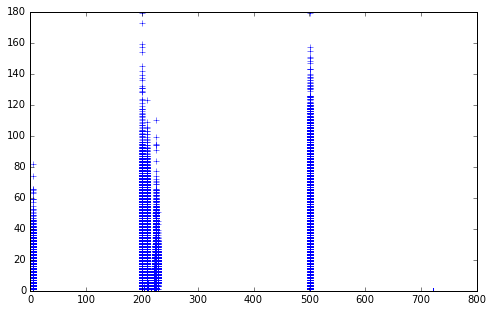

In [24]:
plt.plot(small_df['SPLIT_COD'], small_df[target], '+')

In [258]:
sub = df[df.ASS_ASSIGNMENT == "CAT"]
sub = sub.sort_values(by="DATE")
sub = sub.set_index("DATE")

In [259]:
# select only monday 11:00

In [260]:
monday_11 = sub[sub.dayofweek == 1]
monday_11 = monday_11[monday_11.slot == 22]

In [261]:
# there are several values for the same date, we sum them
s = monday_11.reset_index().groupby("DATE")[target].sum()

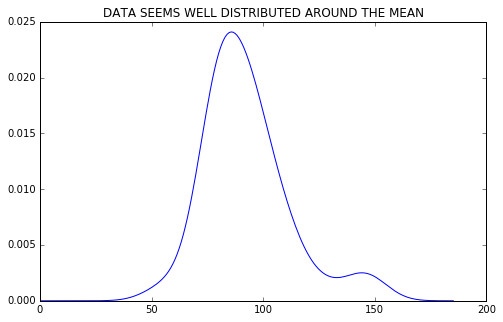

In [262]:
# kernel density estimation
density = gaussian_kde(s)
xs = np.linspace(0, 2*s.mean(), 200)
_ = plt.plot(xs, density(xs))
plt.title("DATA SEEMS WELL DISTRIBUTED AROUND THE MEAN")

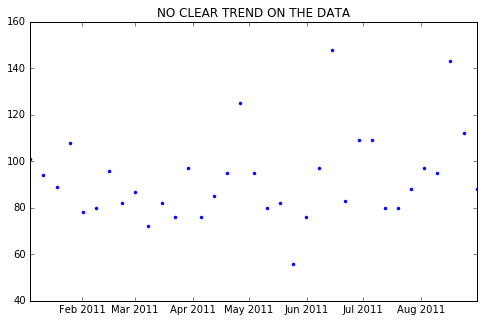

In [263]:
_ = plt.plot(s, '.')
plt.title("NO CLEAR TREND ON THE DATA")

data is well distributed around the mean and there doesn't seem to be any trend ->
#### idea: simple model for predicting 
For each (ASS_ASSIGNMENT, dayOfWeek, timeSlot), we take the values -> we have an s like here.
We find the best constant prediction that minimizes the empirical loss for this time slot.

In [38]:
df = df[['DATE', target, 'ASS_ASSIGNMENT', 'slot']]

In [39]:
1

1

In [126]:
def best_mean(s):
    """The constant that minimizes the empirical loss.
    For numerical stability, we multiply and divide by the max.
    Equal to 1 / alpha * np.log(1 /s.size * np.sum(np.exp(alpha*s)))"""
    s = alpha * s
    m = s.max()
    s = s - m
    return 1 / alpha * (np.log(1/s.size) + m + np.log(np.sum(np.exp(s))))

In [81]:
def get_best_constant(row):
    
    # selecting corresponding time slots in train set
    sub_df = df[(df.ass_hashed == hash(row.ASS_ASSIGNMENT)) & (df.slot == row.slot) & (df.dayofweek == row.dayofweek)]
#     sub_df = sub_df[sub_df.slot == row.slot]
#     sub_df = sub_df[sub_df.dayofweek == row.dayofweek]
    
    if sub_df.empty:
        print("no data for row={}".format(row))
        return 0

    # get the best prediction constant for that loss
    s = sub_df.reset_index().groupby("DATE")[target].sum()
    return best_mean(s)

In [84]:
%%timeit
get_best_constant(df.iloc[10])

10 loops, best of 3: 110 ms per loop


# Read submission data

In [22]:
sub = pd.read_csv('data/submission.txt', sep='\t')

In [23]:
sub.DATE = pd.to_datetime(sub.DATE)

In [17]:
# there are no training data for the submission dates!
sub_ix = sub.set_index('DATE').index
df_ix = df.set_index("DATE").index
df_ix.intersection(sub_ix)

DatetimeIndex([], dtype='datetime64[ns]', name='DATE', freq=None)

In [24]:
sub.shape

(82909, 3)

In [39]:
d = sub.DATE.iloc[0]

In [25]:
sub['dayofweek'] = sub.DATE.apply(lambda x: x.dayofweek)

In [26]:
sub['slot'] = sub.DATE.apply(get_slot)

In [35]:
row = sub.iloc[0]

In [43]:
%%time
get_best_constant(sub.iloc[15])

CPU times: user 503 ms, sys: 12.7 ms, total: 516 ms
Wall time: 515 ms


14.352748662935406

In [55]:
sub.head()

,DATE,ASS_ASSIGNMENT,prediction,dayofweek,slot
0,2012-12-28,CMS,0.0,4,0
1,2012-12-28,Crises,-1.0,4,0
2,2012-12-28,Domicile,-1.0,4,0
3,2012-12-28,Gestion,-1.0,4,0
4,2012-12-28,Gestion - Accueil Telephonique,-1.0,4,0


In [85]:
for i in range(sub.shape[0]):
    if not i % 100:
        print("{} %".format(i / sub.shape[0]))
    sub.loc[i, 'prediction'] = get_best_constant(sub.iloc[i])

0.0 %
0.0012061416734009576 %
0.002412283346801915 %
0.003618425020202873 %
0.00482456669360383 %
0.006030708367004789 %
0.007236850040405746 %
0.008442991713806703 %
0.00964913338720766 %
0.01085527506060862 %
0.012061416734009577 %
0.013267558407410535 %
0.014473700080811492 %
0.01567984175421245 %
0.016885983427613407 %
0.018092125101014364 %
0.01929826677441532 %
0.02050440844781628 %
0.02171055012121724 %
0.022916691794618197 %
0.024122833468019154 %
0.025328975141420112 %
0.02653511681482107 %
0.027741258488222027 %
0.028947400161622984 %
0.03015354183502394 %
0.0313596835084249 %
0.03256582518182586 %
0.03377196685522681 %
0.034978108528627774 %
0.03618425020202873 %
0.03739039187542969 %
0.03859653354883064 %
0.039802675222231604 %
0.04100881689563256 %
0.04221495856903352 %
0.04342110024243448 %
0.04462724191583543 %
0.045833383589236394 %
0.04703952526263735 %
0.04824566693603831 %
0.04945180860943926 %
0.050657950282840224 %
0.05186409195624118 %
0.05307023362964214 %
0.0542

In [194]:
%%time
sub.iloc[30000:, 2] = sub.iloc[30000:].apply(get_best_constant, axis=1)

no data for row=DATE              2013-07-17 18:30:00
ASS_ASSIGNMENT           Prestataires
prediction                          0
dayofweek                           2
slot                               37
Name: 44082, dtype: object
no data for row=DATE              2013-07-17 19:00:00
ASS_ASSIGNMENT           Prestataires
prediction                          0
dayofweek                           2
slot                               38
Name: 44106, dtype: object
no data for row=DATE              2013-07-17 19:30:00
ASS_ASSIGNMENT           Prestataires
prediction                          0
dayofweek                           2
slot                               39
Name: 44129, dtype: object
no data for row=DATE              2013-07-17 20:00:00
ASS_ASSIGNMENT           Prestataires
prediction                          0
dayofweek                           2
slot                               40
Name: 44151, dtype: object
no data for row=DATE              2013-07-17 20:30:00
ASS_ASSIGNMENT

In [86]:
sub.prediction.describe()

count    8.290900e+04
mean              inf
std               NaN
min     -1.110223e-16
25%      0.000000e+00
50%      9.135438e-01
75%      1.521440e+01
max               inf
Name: prediction, dtype: float64

In [142]:
sub.head()

,DATE,ASS_ASSIGNMENT,prediction,dayofweek,slot
0,2012-12-28,CMS,0.000000,4,0
1,2012-12-28,Crises,0.000000,4,0
2,2012-12-28,Domicile,0.299646,4,0
3,2012-12-28,Gestion,0.000000,4,0
4,2012-12-28,Gestion - Accueil Telephonique,0.045581,4,0


In [143]:
real_sub = sub.iloc[:, :3]

In [144]:
real_sub.head()

,DATE,ASS_ASSIGNMENT,prediction
0,2012-12-28,CMS,0.000000
1,2012-12-28,Crises,0.000000
2,2012-12-28,Domicile,0.299646
3,2012-12-28,Gestion,0.000000
4,2012-12-28,Gestion - Accueil Telephonique,0.045581


In [145]:
real_sub.DATE = real_sub.DATE.astype(str) + ".000"

In [146]:
real_sub.to_csv('data/sub3.txt', sep='\t', index=None)

In [208]:
real_sub.prediction = real_sub.prediction.astype(np.int64)